In [94]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import numpy as np


batch_size = 128
vae_batch_size = 512
seed = 1
epochs = 200
rnn_epochs = 10
vae_epochs = 50
cuda = True
log_interval = 10
sample_size = 10
h_d = 512
l_d = 32
u_d = 1



torch.manual_seed(seed)

In [2]:
device = torch.device("cuda" if cuda else "cpu")

kwargs = {'num_workers': 0, 'pin_memory': True} if cuda else {}



### Preparing for the dataset

In [3]:
#hmnist dataset
import healing_mnist_indep
import vae_mnist

In [4]:
hmnist = healing_mnist_indep.HealingMNIST(seq_len=5, # 5 rotations of each digit
                                          square_count=0, # 3 out of 5 images have a square added to them
                                          square_size=5, # the square is 5x5
                                          noise_ratio=0.1, # on average, 20% of the image is eaten by noise,
                                          digits=range(10), # only include this digits
                                          test = False
                                         )

In [5]:
vae = vae_mnist.HealingMNIST(seq_len=5, # 5 rotations of each digit
                                          square_count=0, # 3 out of 5 images have a square added to them
                                          square_size=5, # the square is 5x5
                                          noise_ratio=0.10, # on average, 20% of the image is eaten by noise,
                                          digits=range(10), # only include this digits
                                          test = False
                                         )

In [11]:
print(hmnist.train_images.shape,hmnist.train_targets.shape)
print(hmnist.train_rotations.shape)
print(hmnist.test_images.shape,hmnist.test_targets.shape)
print(hmnist.test_rotations.shape)

(60000, 5, 28, 28) (60000, 5, 28, 28)
(60000, 5)
(10000, 5, 28, 28) (10000, 5, 28, 28)
(10000, 5)


In [12]:
print(vae.train_images.shape,vae.train_targets.shape)

print(vae.test_images.shape,vae.test_targets.shape)

(60000, 6, 28, 28) (60000, 6, 28, 28)
(10000, 6, 28, 28) (10000, 6, 28, 28)


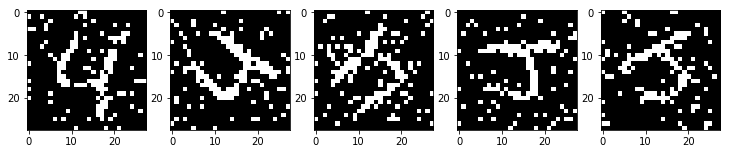

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
case = 4
fig = plt.figure(figsize=(15,8))
for i, image in enumerate(hmnist.test_images[case]):
    fig.add_subplot(1, 6, i+1)
    plt.imshow(image,cmap='gray')
    

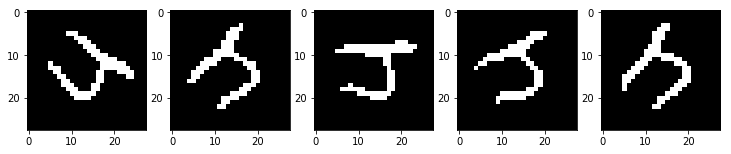

In [14]:
fig = plt.figure(figsize=(15,8))
for i, image in enumerate(hmnist.test_targets[case]):
    fig.add_subplot(1, 6, i+1)
    plt.imshow(image,cmap='gray')

In [15]:
print(hmnist.test_rotations[case])

[ 65.88950329  82.17884058 -44.44024224  23.42226093  27.14671693]


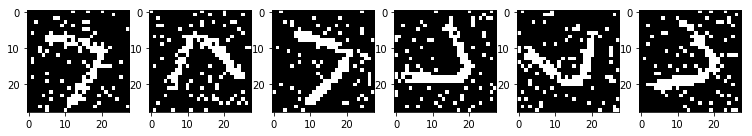

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline
case = 17
fig = plt.figure(figsize=(15,8))
for i, image in enumerate(vae.test_images[case]):
    fig.add_subplot(1, 7, i+1)
    plt.imshow(image,cmap='gray')
    

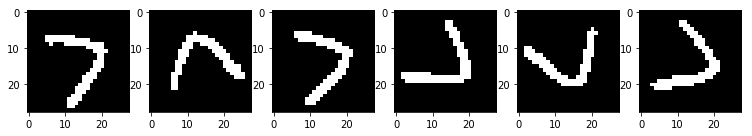

In [17]:
fig = plt.figure(figsize=(15,8))
for i, image in enumerate(vae.test_targets[case]):
    fig.add_subplot(1, 7, i+1)
    plt.imshow(image,cmap='gray')

### Adjust the data shape
this part should be different for different model, the q-RNN model does not igorned the sequencial dependency within the dataset, so we don't need to flat the dataset. So that the dataset should be that given a sequence of noisy image $\{p_i\}$ and a sequences of action $\{u_i\}$, the target should be the image of next timestep given action $u_n$

In [18]:
train_X = hmnist.train_images
train_u = hmnist.train_rotations
train_Y = hmnist.train_targets
test_X = hmnist.test_images
test_u = hmnist.test_rotations
test_Y = hmnist.test_targets
print(train_X.shape,train_u.shape,train_Y.shape)
print(test_X.shape,test_u.shape,test_Y.shape)

(60000, 5, 28, 28) (60000, 5) (60000, 5, 28, 28)
(10000, 5, 28, 28) (10000, 5) (10000, 5, 28, 28)


In [19]:
#no adjustment needed

#train_Y = train_Y[:,4,:,:]
#test_Y = test_Y[:,4,:,:]

print(train_X.shape,train_u.shape,train_Y.shape)
print(test_X.shape,test_u.shape,test_Y.shape)

(60000, 5, 28, 28) (60000, 5) (60000, 5, 28, 28)
(10000, 5, 28, 28) (10000, 5) (10000, 5, 28, 28)


In [20]:
vae_train_X = vae.train_images
vae_train_Y = vae.train_targets
vae_test_X = vae.test_images
vae_test_Y = vae.test_targets
print(vae_train_X.shape,vae_train_Y.shape)
print(vae_test_X.shape,vae_test_Y.shape)

(60000, 6, 28, 28) (60000, 6, 28, 28)
(10000, 6, 28, 28) (10000, 6, 28, 28)


In [21]:
#for the above six parameter, flaten the first two dimension
vae_train_X = vae_train_X.reshape(-1,28,28)
vae_train_Y = vae_train_Y.reshape(-1,28,28)
vae_test_X = vae_test_X.reshape(-1,28,28)
vae_test_Y = vae_test_Y.reshape(-1,28,28)
print(vae_train_X.shape,vae_train_Y.shape)
print(vae_test_X.shape,vae_test_Y.shape)

(360000, 28, 28) (360000, 28, 28)
(60000, 28, 28) (60000, 28, 28)


### Dataset object

In [22]:
class HMNISTDataSet():
    def __init__(self, train_img, train_act, train_tar, test_img, test_act, test_tar, test = False, transform=None):
        self.test = test
        self.transform = transform

        if (self.test == False):
          self.images = train_img
          self.targets = train_tar
          self.rotations = train_act

        else:      
          self.images = test_img
          self.targets = test_tar
          self.rotations = test_act

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        if self.transform is not None:
            img = torch.zeros((len(self.images[index]),1,28,28))
            for i in range(len(self.images[index])):
                img[i] = self.transform(self.images[index][i].reshape(28,28,1))
            tar = torch.zeros((len(self.targets[index]),1,28,28))
            for i in range(len(self.targets[index])):
                tar[i] = self.transform(self.targets[index][i].reshape(28,28,1))
                
            rot = torch.tensor(self.rotations[index])
        return img, rot, tar

In [23]:
class VAEDataSet():
    def __init__(self, train_img, train_tar, test_img, test_tar, test = False, transform=None):
        self.test = test
        self.transform = transform

        if (self.test == False):
          self.images = train_img
          self.targets = train_tar


        else:      
          self.images = test_img
          self.targets = test_tar


    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        if self.transform is not None:
            img = self.transform(self.images[index].reshape(28,28,1))
            tar = self.transform(self.targets[index].reshape(28,28,1))
        return img, tar

In [24]:
train_set = HMNISTDataSet(train_X, train_u, train_Y, test_X, test_u, test_Y, test = False, transform = transforms.ToTensor())
test_set = HMNISTDataSet(train_X, train_u, train_Y, test_X, test_u, test_Y, test = True, transform = transforms.ToTensor())

In [25]:
vae_train_set = VAEDataSet(vae_train_X, vae_train_Y, vae_test_X, vae_test_Y, test = False, transform = transforms.ToTensor())
vae_test_set = VAEDataSet(vae_train_X, vae_train_Y, vae_test_X, vae_test_Y, test = True, transform = transforms.ToTensor())

In [26]:
a,b = vae_train_set.__getitem__(3)
b.shape


torch.Size([1, 28, 28])

### Create DataLoader

In [27]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True, **kwargs)

In [28]:
vae_train_loader = torch.utils.data.DataLoader(vae_train_set, batch_size=vae_batch_size, shuffle=True, **kwargs)
vae_test_loader = torch.utils.data.DataLoader(vae_test_set, batch_size=vae_batch_size, shuffle=True, **kwargs)

### Model definition

In [42]:
# the purpose of this model is to examine whether pretrain vae is possible or not

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, h_d)
        self.fc2 = nn.Linear(h_d,128)
        self.fc21 = nn.Linear(128, l_d)
        self.fc22 = nn.Linear(128, l_d)
        
        #transition layer
        input_dim = l_d + u_d
        self.rnn_mu = nn.RNN(input_size=input_dim,hidden_size=l_d,batch_first=True)
        self.rnn_sigma = nn.RNN(input_size=input_dim,hidden_size=l_d,batch_first=True)
        
        
        self.fc3 = nn.Linear(l_d, 128)
        self.fc4 = nn.Linear(128,h_d)
        self.fc5 = nn.Linear(h_d, 784)

    def encode(self, x):
        x = x.float()
        h1 = F.relu(self.fc1(x))
        h2 = F.relu(self.fc2(h1))
        return self.fc21(h2), self.fc22(h2)

    def reparameterize1(self, mu, logvar, n=1):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std
    
    def transition(self, z, u):
        rnn_input = torch.cat((z,u),dim=2)
        mu2,_ = self.rnn_mu(rnn_input)
        logvar2,_ = self.rnn_sigma(rnn_input)
        return mu2,logvar2
    
    def reparameterize2(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        h4 = F.relu(self.fc4(h3))
        return torch.sigmoid(self.fc5(h4))

    def forward(self, x=None,mu_i=None,logvar_i=None,u=None, vae=False, rnn=False):
        if vae:
            mu1, logvar1 = self.encode(x.view(-1, 784))
            z1 = self.reparameterize1(mu1, logvar1)
            return self.decode(z1), mu1, logvar1
        elif rnn:
            mu = torch.empty(sample_size, x.shape[0], x.shape[1], l_d , dtype=torch.float).to(device)
            logvar = torch.empty(sample_size, x.shape[0], x.shape[1], l_d , dtype=torch.float).to(device)
            for i in range(sample_size):
                z1 = self.reparameterize1(mu_i, logvar_i)
                z1 = z1.reshape(-1,5,32)
                u = u.float()
                mu2, logvar2 = self.transition(z1,u.reshape(-1,5,1))
                mu[i] = mu2
                logvar[i] = logvar2
            return mu, logvar
        else:
            mu1, logvar1 = self.encode(x.view(-1, 784))
            mu = torch.empty(sample_size, x.shape[0], x.shape[1], l_d , dtype=torch.float).to(device)
            logvar = torch.empty(sample_size, x.shape[0], x.shape[1], l_d , dtype=torch.float).to(device)
            for i in range(sample_size):
                z1 = self.reparameterize1(mu1, logvar1)
                z1 = z1.reshape(-1,5,32)
                u = u.float()
                mu2, logvar2 = self.transition(z1,u.reshape(-1,5,1))
                mu[i] = mu2
                logvar[i] = logvar2
            z2 = self.reparameterize2(mu[0], logvar[0])
            return self.decode(z2), mu, logvar

In [44]:
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar[0,:,0,:] - mu[0,:,0,:].pow(2) - logvar[0,:,0,:].exp())
    EKLD = 0
    for i in range(1,5):        
        tmp = -0.5 * torch.sum(1 + logvar[:,:,i,:] - mu[:,:,i,:].pow(2) - logvar[:,:,i,:].exp())/sample_size
        EKLD += tmp
    return BCE + KLD + EKLD

In [45]:
# Reconstruction + KL divergence losses summed over all elements and batch
def vae_loss_function(recon_x, x, mu, logvar):
    x = x.float()
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

In [46]:
# Reconstruction + KL divergence losses summed over all elements and batch
def rnn_loss_function(mu, logvar):

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar[0,:,0,:] - mu[0,:,0,:].pow(2) - logvar[0,:,0,:].exp())
    EKLD = 0
    for i in range(1,5):        
        tmp = -0.5 * torch.sum(1 + logvar[:,:,i,:] - mu[:,:,i,:].pow(2) - logvar[:,:,i,:].exp())/sample_size
        EKLD += tmp
    return KLD + EKLD

### Define training and testing algorithm

In [96]:
def train_vae():
    #freeze the rnn layer first
    count = 0
    for child in model.children():
        if count == 4 or count == 5:
            for param in child.parameters():
                param.requires_grad = False;
        count += 1;
    
    model.train()
    for i in range(vae_epochs):
        train_loss = 0
        for batch_idx, (img, target) in enumerate(vae_train_loader):
            img = img.cuda()
            target = target.cuda()
            optimizer.zero_grad()
            recon_batch, mu, logvar = model.forward(x=img,vae=True)
            loss = vae_loss_function(recon_batch, target, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()

        print('====> Epoch: {} Average loss: {:.4f}'.format(
              i + 1, train_loss / len(vae_train_loader.dataset)))
    print("vae pretrain has been done")

In [97]:
def finish_vae():
    for child in model.children():
        for param in child.parameters():
            param.requires_grad = True;
    print("ready for rnn model train")

In [98]:
def train_rnn():
    #freeze the vae layer first
    count = 0
    for child in model.children():
        if count != 4 or count != 5:
            for param in child.parameters():
                param.requires_grad = False;
        count += 1;
    
    model.train()
    for i in range(rnn_epochs):
        train_loss = 0
        for batch_idx, (img, action, target) in enumerate(train_loader):     
            img = img.to(device)
            action = action.to(device)
            target = target.to(device)
            with torch.no_grad():
                mu, logvar = model.encode(img.view(-1, 784))
                
            optimizer.zero_grad()
            mu.requires_grad = True
            logvar.requires_grad = True
            mu1, logvar1 = model.forward(x=img,u=action,mu_i=mu,logvar_i=logvar,rnn=True)
            loss = rnn_loss_function(mu1, logvar1)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
        print('====> Epoch: {} Average loss: {:.4f}'.format(
              i + 1, train_loss / len(vae_train_loader.dataset)))
    print("rnn pretrain has been done")

In [99]:
def finish_rnn():
    for child in model.children():
        for param in child.parameters():
            param.requires_grad = True;
    print("ready for the whole model train")

In [100]:
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (img, action, target) in enumerate(train_loader):
        img = img.to(device)
        action = action.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(x=img,u=action)
        loss = loss_function(recon_batch, target, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        #if batch_idx % log_interval == 0:
         #   print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
          #      epoch, batch_idx * len(img), len(train_loader.dataset),
           #     100. * batch_idx / len(train_loader),
            #    loss.item() / len(img)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))
    return train_loss / len(train_loader.dataset)

In [101]:
def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (img, action, target) in enumerate(test_loader):
            img = img.to(device)
            action = action.to(device)
            target = target.to(device)
            recon_batch, mu, logvar = model(x=img, u=action)
            test_loss += loss_function(recon_batch, target, mu, logvar).item()
            if(epoch > epochs - 10):
                if i == 0:
                    n = np.random.randint(0,batch_size)
                    comparison = torch.cat([target[n],
                                          recon_batch.view(batch_size, 5, 1, 28, 28)[n]],dim=0)
                    save_image(comparison.cpu(),
                             'results/reconstruction_' + str(epoch) + '.png', nrow=5)

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))
    return test_loss

### Run training

In [95]:
model = VAE().to(device)
#adam optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [102]:
train_vae()
finish_vae()

====> Epoch: 1 Average loss: 192.0418
====> Epoch: 2 Average loss: 142.9048
====> Epoch: 3 Average loss: 129.1424
====> Epoch: 4 Average loss: 122.7451
====> Epoch: 5 Average loss: 118.9887
====> Epoch: 6 Average loss: 116.3216
====> Epoch: 7 Average loss: 114.4632
====> Epoch: 8 Average loss: 113.1223
====> Epoch: 9 Average loss: 112.0737
====> Epoch: 10 Average loss: 111.2387
====> Epoch: 11 Average loss: 110.5473
====> Epoch: 12 Average loss: 109.9740
====> Epoch: 13 Average loss: 109.4127
====> Epoch: 14 Average loss: 109.0301
====> Epoch: 15 Average loss: 108.6125
====> Epoch: 16 Average loss: 108.2380
====> Epoch: 17 Average loss: 107.8842
====> Epoch: 18 Average loss: 107.6355
====> Epoch: 19 Average loss: 107.3292
====> Epoch: 20 Average loss: 107.0471
====> Epoch: 21 Average loss: 106.8174
====> Epoch: 22 Average loss: 106.6014
====> Epoch: 23 Average loss: 106.4046
====> Epoch: 24 Average loss: 106.1653
====> Epoch: 25 Average loss: 105.9837
====> Epoch: 26 Average loss: 105.

In [103]:
import warnings;
warnings.filterwarnings('ignore')

train_rnn()
finish_rnn()

====> Epoch: 1 Average loss: 16.6551
====> Epoch: 2 Average loss: 16.6551
====> Epoch: 3 Average loss: 16.6553
====> Epoch: 4 Average loss: 16.6554
====> Epoch: 5 Average loss: 16.6553
====> Epoch: 6 Average loss: 16.6547
====> Epoch: 7 Average loss: 16.6553
====> Epoch: 8 Average loss: 16.6549
====> Epoch: 9 Average loss: 16.6551
====> Epoch: 10 Average loss: 16.6552
rnn pretrain has been done
ready for the whole model train


In [104]:

train_losses = []
test_losses = []
for epoch in range(1, epochs + 1):
    train_loss = train(epoch)
    test_loss = test(epoch)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    with torch.no_grad():
        if(epoch > epochs - 10):
            sample = torch.randn(64, l_d).to(device)
            sample = model.decode(sample).cpu()
            save_image(sample.view(64, 1, 28, 28),
                       'results/sample_' + str(epoch) + '.png')


====> Epoch: 1 Average loss: 1072.0767
====> Test set loss: 977.3884
====> Epoch: 2 Average loss: 957.7257
====> Test set loss: 938.1437
====> Epoch: 3 Average loss: 926.3934
====> Test set loss: 911.8797
====> Epoch: 4 Average loss: 904.6363
====> Test set loss: 894.8882
====> Epoch: 5 Average loss: 890.9514
====> Test set loss: 884.1969
====> Epoch: 6 Average loss: 881.7021
====> Test set loss: 875.1841
====> Epoch: 7 Average loss: 873.5355
====> Test set loss: 868.2546
====> Epoch: 8 Average loss: 866.3834
====> Test set loss: 863.9958
====> Epoch: 9 Average loss: 860.5858
====> Test set loss: 857.3587
====> Epoch: 10 Average loss: 856.0688
====> Test set loss: 854.2608
====> Epoch: 11 Average loss: 852.2928
====> Test set loss: 851.9351
====> Epoch: 12 Average loss: 848.4045
====> Test set loss: 847.2105
====> Epoch: 13 Average loss: 845.3711
====> Test set loss: 843.7339
====> Epoch: 14 Average loss: 842.5777
====> Test set loss: 842.6448
====> Epoch: 15 Average loss: 839.5112
===

====> Test set loss: 797.5992
====> Epoch: 120 Average loss: 785.3688
====> Test set loss: 798.2648
====> Epoch: 121 Average loss: 785.0113
====> Test set loss: 796.8887
====> Epoch: 122 Average loss: 785.3412
====> Test set loss: 797.0159
====> Epoch: 123 Average loss: 785.4243
====> Test set loss: 798.9056
====> Epoch: 124 Average loss: 784.9404
====> Test set loss: 798.4592
====> Epoch: 125 Average loss: 784.5412
====> Test set loss: 798.3335
====> Epoch: 126 Average loss: 784.4241
====> Test set loss: 797.3208
====> Epoch: 127 Average loss: 784.6552
====> Test set loss: 797.3448
====> Epoch: 128 Average loss: 784.6793
====> Test set loss: 796.3907
====> Epoch: 129 Average loss: 784.2438
====> Test set loss: 797.2036
====> Epoch: 130 Average loss: 784.4245
====> Test set loss: 798.3585
====> Epoch: 131 Average loss: 784.3349
====> Test set loss: 795.9591
====> Epoch: 132 Average loss: 783.8246
====> Test set loss: 796.5787
====> Epoch: 133 Average loss: 783.7961
====> Test set loss:

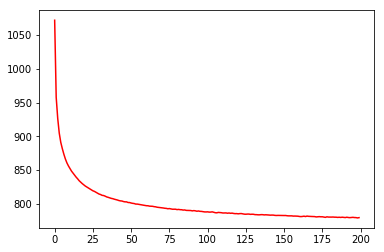

In [105]:
plt.plot(np.array(train_losses),'r')
plt.show()

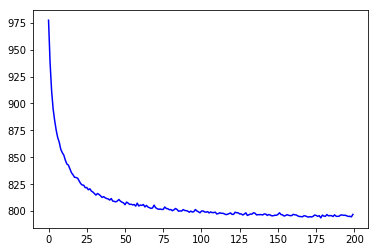

In [106]:
plt.plot(np.array(test_losses),'b')
plt.show()